## Customer Model Behavior Analysis
---

* customer model behavior
    * [force plot](https://docs.google.com/document/d/1_xQoyimEkDi-Guoml2MxS6wXQATmy8D27iSsQ4LIAzY/edit) for missing fraud_score_1
    * [detailed feature importance](https://docs.google.com/spreadsheets/d/1YZEXwaCuxTTXL5skdSz_ZdIZujr2kUhQaK076Sy4KK4/edit#gid=0)
    
  OOT samples in 2021 from dropping fraud_score_1 entirely and changing missing name_address_correlation to 1

In [1]:
import sys, os, json
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
import copy

from smart_open import open
import pickle as pkl
import src.monitoring.utils as mu

from src.utils import scale_scores
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

plt.style.use("seaborn")

In [2]:
# load models

with open("../../config.json", "r") as f:
    config = json.load(f)
    mpaths = config["monitoring_config"]["model_paths"]
    
with open(mpaths["incumbent_model"], "rb") as f:
    incumbent_model = pkl.load(f)
    
with open(mpaths["customer_refitted_2021Q1"], "rb") as f:
    refitted_model = pkl.load(f)

In [9]:
df = pd.read_feather("../../data/combined_all_features/combined_1629343029.feather")
df = df[df.is_static]

In [10]:
df.shape

(1867207, 91)

In [11]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 590, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

In [12]:
# other setups
features = incumbent_model.feature_name_

df = mu.prep_customer_data(df)  # get is_active here
print(df[["sample_date", "is_active"]].value_counts())

df["pred_incumbent"] = incumbent_model.predict_proba(df[features])[:,1]
df["pred_refitted"] = refitted_model.predict_proba(df[features])[:,1]

df["score_incumbent"] = mu.scale_scores(df["pred_incumbent"])
df["score_refitted"] = mu.scale_scores(df["pred_refitted"])

df["rg_incumbent"] = get_risk_groups(df["score_incumbent"])
df["rg_refitted"] = get_risk_groups_refitted(df["score_refitted"])

sample_date  is_active
2021-07-01   False        794889
2021-06-01   False        757037
2021-07-01   True         163346
2021-06-01   True         151935
dtype: int64


In [13]:
june_df = df[df.sample_date==pd.to_datetime("2021-06-01")]
july_df = df[df.sample_date==pd.to_datetime("2021-07-01")]

<AxesSubplot:>

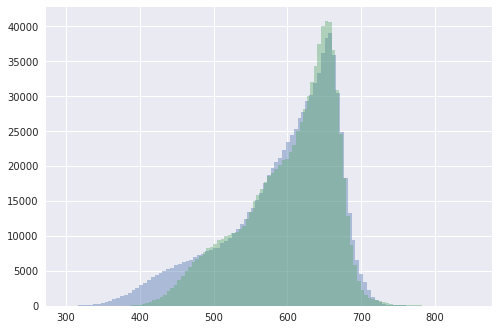

In [19]:
june_df.score_incumbent.hist(bins=100, alpha=0.4)
june_df.score_refitted.hist(bins=100, alpha=0.4)

<AxesSubplot:>

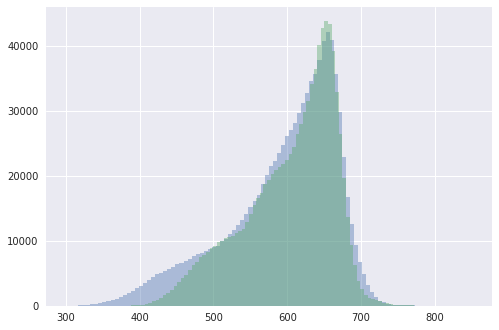

In [20]:
july_df.score_incumbent.hist(bins=100, alpha=0.4)
july_df.score_refitted.hist(bins=100, alpha=0.4)

In [16]:
june_df.shape, july_df.shape

((908972, 104), (958235, 104))

In [15]:
cols = ["business_account_number", "borrower_id", "sample_date", 
        "pred_incumbent", "pred_refitted", "score_incumbent", "score_refitted",
        "rg_incumbent", "rg_refitted"]
june_df[cols].to_csv("s3://sofi-data-science/jxu/data_dump/money_customer_risk/202106-scores.csv")
july_df[cols].to_csv("s3://sofi-data-science/jxu/data_dump/money_customer_risk/202107-scores.csv")